In [69]:
#Import necessary packages:
import xarray as xr
import rio_cogeo.cogeo
import matplotlib.pyplot as plt
import h5py
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from scipy.interpolate import RegularGridInterpolator


In [2]:
#Inspect source NetCDF files:
#file = 'raw-data/VIIRS/VIIRS_test_data.nc'
file = 'raw-data/VIIRS/GIMGO-SVI05_j01_d20240626_t0232467_e0238268_b34217_c20241017035358056139_oebc_ops.h5'

In [79]:
# Step 1: Open the HDF5 file and extract the necessary datasets
with h5py.File(file, 'r') as f:
    # Access the Brightness Temperature, Latitude, and Longitude datasets
    brightness_temp = f['All_Data/VIIRS-I5-SDR_All/BrightnessTemperature'][:]
    latitudes = f['All_Data/VIIRS-IMG-GEO_All/Latitude'][:]
    longitudes = f['All_Data/VIIRS-IMG-GEO_All/Longitude'][:]
    brightness_temp_factors = f['All_Data/VIIRS-I5-SDR_All/BrightnessTemperatureFactors'][:]

In [80]:
# Step 2: Extract the scale factor and offset
scale_factor = brightness_temp_factors[0]  
offset = brightness_temp_factors[1] if len(brightness_temp_factors) > 1 else 0 

# Step 3: Apply the scale factor and offset to the brightness temperature
brightness_temp = (brightness_temp * scale_factor) + offset  # Converts to Kelvin

# Step 4: Create an xarray DataArray with lat/lon as coordinates
brightness_temp_da = xr.DataArray(
    brightness_temp,
    dims=["y", "x"],
    coords={"lat": (["y", "x"], latitudes), "lon": (["y", "x"], longitudes)},
    name="BrightnessTemperature"
)

# Step 5: Ensure proper lat/lon coordinates and CRS
brightness_temp_da = brightness_temp_da.rio.write_crs("EPSG:4326", inplace=True)

# Step 6: Save the georeferenced data to a COG (Cloud Optimized GeoTIFF)
cog_filename = "test_cog_VIIRS.tif"
brightness_temp_da.rio.to_raster(cog_filename, driver="COG")

In [81]:
# Step 7: Validate the COG file to ensure it's properly formatted
cog_valid = rio_cogeo.cogeo.cog_validate(cog_filename)
print(f"COG validation: {cog_valid}")

COG validation: (True, [], [])


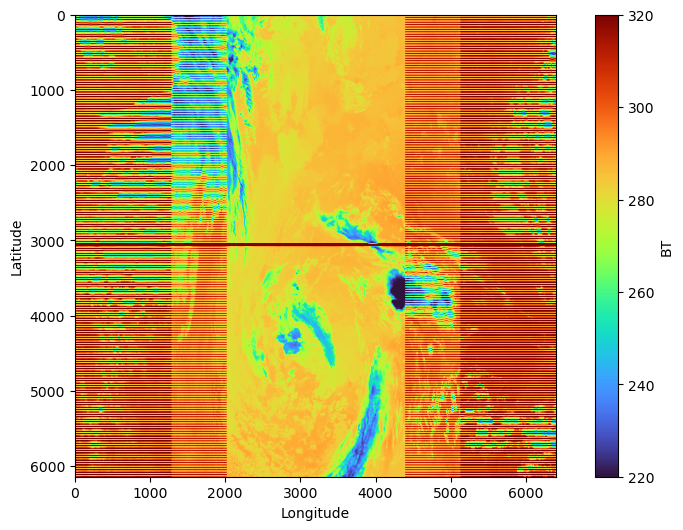

In [82]:
# Path to the Cloud Optimized GeoTIFF (COG)
cog_filename = "test_cog_VIIRS.tif"

# Open the COG file using rasterio
with rasterio.open(cog_filename) as src:
    # Read the data from the COG
    data = src.read(1)  # Reading the first band (radiance data)
    
    # Get the bounds (left, bottom, right, top) of the dataset in geographic coordinates
    bounds = src.bounds
    extent = [bounds.left, bounds.right, bounds.bottom, bounds.top]
    
    # Set up a figure
    plt.figure(figsize=(10, 6))
    
    # Plot the data using imshow and set the extent to geographic bounds
    plt.imshow(data, cmap='turbo', extent=extent, origin='upper', vmax = 320, vmin = 220)
    
    # Add labels and title
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')

    # Add a colorbar
    plt.colorbar(label="BT")

    # Display the plot
    plt.show()